# Assignment 2  Random Walk Metrics

**Name:** Milagros Contreras Elizalde 

**e-mail:** milagros.contreras8430@alumnos.udg.mx

# Modules


In [42]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from scipy.spatial import distance
from scipy.stats import cauchy
from scipy.stats import levy_stable


# Loading Data from CSV Files


In [22]:
# load CSV
brownian_3 = pd.read_csv(r'C:\Users\herik\Documents\Assignment 2_MCE\csv\brownian_3.csv')
brownian_6 = pd.read_csv(r'C:\Users\herik\Documents\Assignment 2_MCE\csv\brownian_6.csv')
crw_6_6 = pd.read_csv(r'C:\Users\herik\Documents\Assignment 2_MCE\csv\crw_6_6.csv')
data_crw_9 = pd.read_csv(r'C:\Users\herik\Documents\Assignment 2_MCE\csv\crw_6_9.csv')



# Activity 1: Path length - (BM1 vs BM2 vs CRW) 


- *Function to calculate the cumulative length of a path:*

This function calculates the cumulative length of a path given a DataFrame with x and y coordinates. It calculates the Euclidean distance between successive points and records the sum of these distances to determine the cumulative path length at each step. The result is a list of path lengths showing the increments over time.


In [17]:

# Función para calcular la longitud acumulada del camino
def calculate_accumulated_path_length(df):
    points = df[['x_pos', 'y_pos']].values
    accumulated_lengths = [0]
    for i in range(1, len(points)):
        accumulated_lengths.append(accumulated_lengths[-1] + distance.euclidean(points[i-1], points[i]))
    return accumulated_lengths



- *Calculate Accumulated Path Lengths*


In [18]:
BM_path_length_3 = calculate_accumulated_path_length(brownian_3)
BM_path_length_6 = calculate_accumulated_path_length(brownian_6)
CRW_path_length = calculate_accumulated_path_length(crw_6_6)

- *Create the Figure Using Plotly*

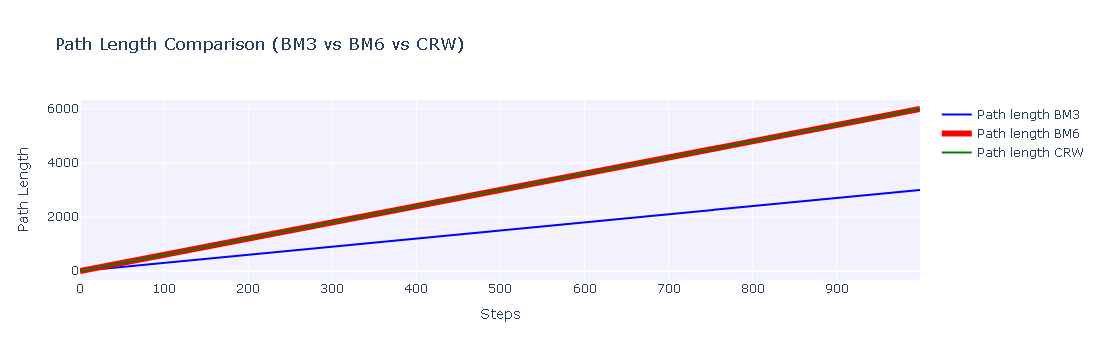

In [19]:

# Creación de la figura usando plotly
fig = go.Figure()

# Añadir trayectorias desde los archivos CSV (longitud acumulada)
fig.add_trace(go.Scatter(
    x=list(range(len(BM_path_length_3))),
    y=BM_path_length_3,
    mode='lines',
    name='Path length BM3',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(len(BM_path_length_6))),
    y=BM_path_length_6,
    mode='lines',
    name='Path length BM6',
    line=dict(color='red', width=6)
))

fig.add_trace(go.Scatter(
    x=list(range(len(CRW_path_length))),
    y=CRW_path_length,
    mode='lines',
    name='Path length CRW',
    line=dict(color='green')
))

# Configuración de la figura
fig.update_layout(
    title="Path Length Comparison (BM3 vs BM6 vs CRW)",
    xaxis_title="Steps",
    yaxis_title="Path Length",
    showlegend=True,
    plot_bgcolor='rgba(230, 230, 255, 0.5)'
)

# Mostrar la figura
fig.show()


# Activity 2: Mean Squared Displacement - (BM vs CRW)

In [24]:
# Convert DataFrames to numpy arrays for positions
BM_2d_df_6 = brownian_6[['x_pos', 'y_pos']].values
CRW_2d_df_6 = data_crw_9[['x_pos', 'y_pos']].values

# Parameters for the calculation
n = 200

 Calculates the Mean Squared Displacement (MSD) of a set of positions over time.

    Parameters:
    positions (array): Series of positions in 2D array format.
    n (int): Number of steps to calculate distances.

    Returns:
    msd (array): Calculated MSD for each time step.

    **formula/code relationship**

$$
\text{MSD}(t) = \frac{1}{N - t} \sum_{i=1}^{N-t} \left| \mathbf{r}(i+t) - \mathbf{r}(i) \right|^2
$$


In [25]:
def calculate_msd(positions, n):
    num_steps = len(positions) - n
    msd = np.zeros(num_steps)

    # Calculate MSD for each time step
    for t in range(1, num_steps):
        squared_displacements = np.zeros(num_steps - t)
        for i in range(num_steps - t):
            displacement = positions[i + t] - positions[i]
            squared_displacements[i] = np.dot(displacement, displacement)  # Squared distance
        msd[t] = np.mean(squared_displacements)

    return msd

- Calculate MSD for BM and CRW with data CSV

In [28]:
msd_bm = calculate_msd(BM_2d_df_6, n)
msd_crw = calculate_msd(CRW_2d_df_6, n)

plot with ploty

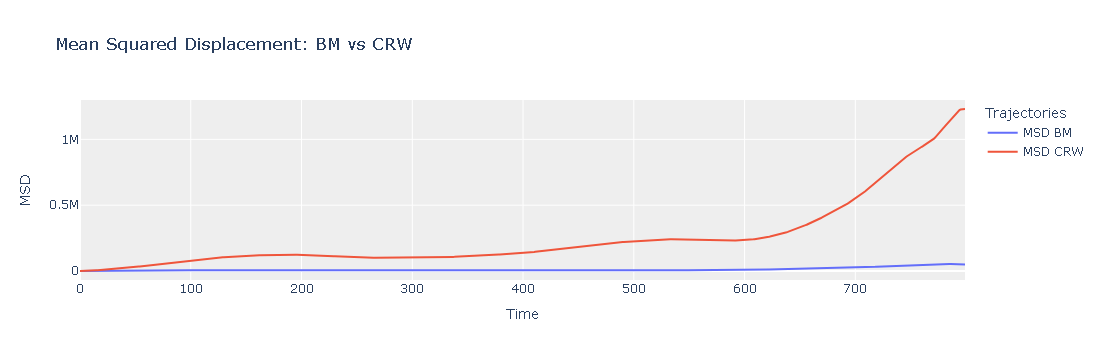

In [29]:



# Create the Plotly figure
fig = go.Figure()

# Add MSD curves for BM and CRW
fig.add_trace(go.Scatter(x=np.arange(len(msd_bm)), y=msd_bm, mode='lines', name='MSD BM'))
fig.add_trace(go.Scatter(x=np.arange(len(msd_crw)), y=msd_crw, mode='lines', name='MSD CRW'))

# Configure the layout of the plot
fig.update_layout(
    title='Mean Squared Displacement: BM vs CRW',
    xaxis_title='Time',
    yaxis_title='MSD',
    legend_title='Trajectories',
    plot_bgcolor='rgba(200, 200, 200, 0.3)'
)

# Display the plot
fig.show()


# Activity 3: Turning-angle Distribution - (source dist. vs observed dist.)

- The turning_angles function calculates turning angles between consecutive path segments. Here's how it works, including the characteristic formula used:

In [ ]:
def turning_angles(coords):
    angles = []
    coords = np.hstack((coords, np.zeros((coords.shape[0], 1))))  # Convert to 3D vectors
    for i in range(1, len(coords) - 1):
        a = coords[i - 1]
        b = coords[i]
        c = coords[i + 1]

        # Calculate vectors
        ab = b - a
        bc = c - b

        # Normalize the vectors
        norm_ab = np.linalg.norm(ab)
        norm_bc = np.linalg.norm(bc)
        if norm_ab == 0 or norm_bc == 0:
            continue  # Avoid division by zero if vectors are too small

        # Dot product and cross product
        dot_p = np.dot(ab, bc)
        cross_p = np.cross(ab, bc)

        # Angle between vectors
        epsilon = np.finfo(float).eps
        theta = np.arccos(np.clip(dot_p / (norm_ab * norm_bc), -1 + epsilon, 1 - epsilon))

        # Determine orientation using the sign of the cross product
        orient = np.sign(cross_p[2])  # Use the z-component for orientation
        if orient == 0:
            orient = 1  # Assign orientation if perpendicular

        # Adjust angle with orientation
        theta = theta * orient

        angles.append(theta)

    return np.array(angles)

The characteristic formula for calculating the turning angle $\theta$ between two vectors $\mathbf{ab}$ and $\mathbf{bc}$ is:

$$
\theta = \arccos\left(\frac{\mathbf{ab} \cdot \mathbf{bc}}{\|\mathbf{ab}\| \|\mathbf{bc}\|}\right) \cdot \text{sign}\left(\mathbf{ab} \times \mathbf{bc}\right)
$$

Where:

- $\mathbf{ab} = \mathbf{b} - \mathbf{a}$
- $\mathbf{bc} = \mathbf{c} - \mathbf{b}$
- $\mathbf{ab} \cdot \mathbf{bc}$ is the dot product
- $\|\mathbf{ab}\|$ and $\|\mathbf{bc}\|$ are the magnitudes of the vectors
- $\mathbf{ab} \times \mathbf{bc}$ is the cross product, with its z-component determining the orientation

This formula calculates the angle between vectors and adjusts it based on the direction of rotation.


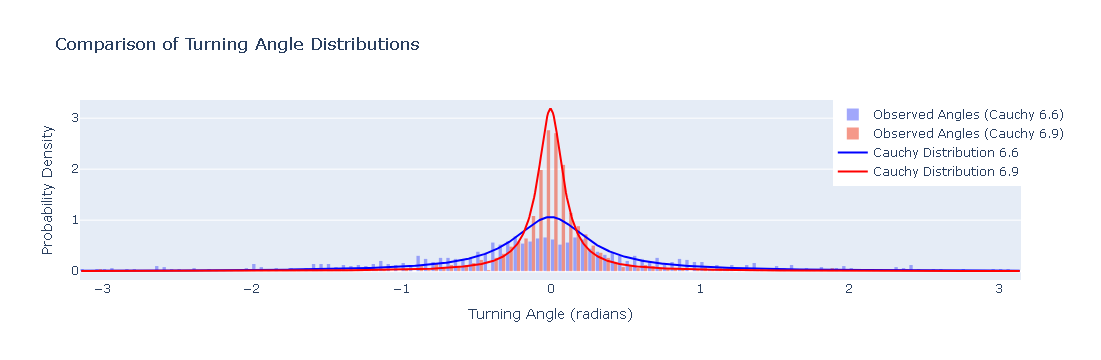

In [34]:

# Extract coordinates from the trajectories
coords_traj1 = crw_6_6[['x_pos', 'y_pos']].values
coords_traj2 = data_crw_9[['x_pos', 'y_pos']].values

# Calculate turning angles for both trajectories
angles_traj1 = turning_angles(coords_traj1)
angles_traj2 = turning_angles(coords_traj2)

# Define the Cauchy distribution with different parameters for both trajectories
x_vals = np.linspace(-np.pi, np.pi, 1000)
cauchy_traj1 = cauchy.pdf(x_vals, scale=0.3)
cauchy_traj2 = cauchy.pdf(x_vals, scale=0.1)

# Create the figure for comparing distributions
fig = go.Figure()

# Add histogram of observed angles for trajectory 1
fig.add_trace(go.Histogram(
    x=angles_traj1,
    histnorm='probability density',
    nbinsx=130,
    name='Observed Angles (Cauchy 6.6)',
    opacity=0.6
))

# Add histogram of observed angles for trajectory 2
fig.add_trace(go.Histogram(
    x=angles_traj2,
    histnorm='probability density',
    nbinsx=130,
    name='Observed Angles (Cauchy 6.9)',
    opacity=0.6
))

# Add theoretical Cauchy curve for trajectory 1
fig.add_trace(go.Scatter(
    x=x_vals,
    y=cauchy_traj1,
    mode='lines',
    name='Cauchy Distribution 6.6',
    line=dict(color='blue')
))

# Add theoretical Cauchy curve for trajectory 2
fig.add_trace(go.Scatter(
    x=x_vals,
    y=cauchy_traj2,
    mode='lines',
    name='Cauchy Distribution 6.9',
    line=dict(color='red')
))

# Adjust the layout of the figure
fig.update_layout(
    title='Comparison of Turning Angle Distributions',
    xaxis_title='Turning Angle (radians)',
    yaxis_title='Probability Density',
    bargap=0.1,
    hovermode="x",
    legend=dict(x=0.8, y=1.0)
)

# Show the figure
fig.show()


# Activity 4: Step-length Distribution

- this a function that returns a Lévy Walk (LW) trajectory in pandas df.

In [45]:
def levy_walk(alpha, beta, n_steps, dim=1, scale=1):
    """
    Generates a Lévy Walk trajectory that starts at 0 and grows positively.
    """
    step_lengths = np.abs(levy_stable.rvs(alpha, beta, size=n_steps, scale=scale))
    directions = np.random.randn(n_steps, dim)
    directions /= np.linalg.norm(directions, axis=1)[:, None]
    positions = np.zeros((n_steps, dim))
    for i in range(1, n_steps):
        positions[i] = positions[i - 1] + step_lengths[i] * directions[i]
    df = pd.DataFrame(positions, columns=[f'x{i + 1}' for i in range(dim)])
    df['step_length'] = step_lengths
    return df


- Function the step lengths for a given trajectory. 

In [46]:
def get_step_lengths(trajectory):
    """
    Extracts step lengths from a Lévy Walk trajectory DataFrame.
    """
    return trajectory['step_length'].values

- Define two LW trajectories with different alpha coefficients.

In [47]:
# Define parameters for the two Lévy Walk trajectories
alpha1, beta1 = 0.7, 1.0
alpha2, beta2 = 0.5, 1.0
n_steps = 200

# Generate the Lévy Walk trajectories
lw1 = levy_walk(alpha1, beta1, n_steps)
lw2 = levy_walk(alpha2, beta2, n_steps)

# Extract step lengths from the trajectories
step_lengths1 = get_step_lengths(lw1)
step_lengths2 = get_step_lengths(lw2)

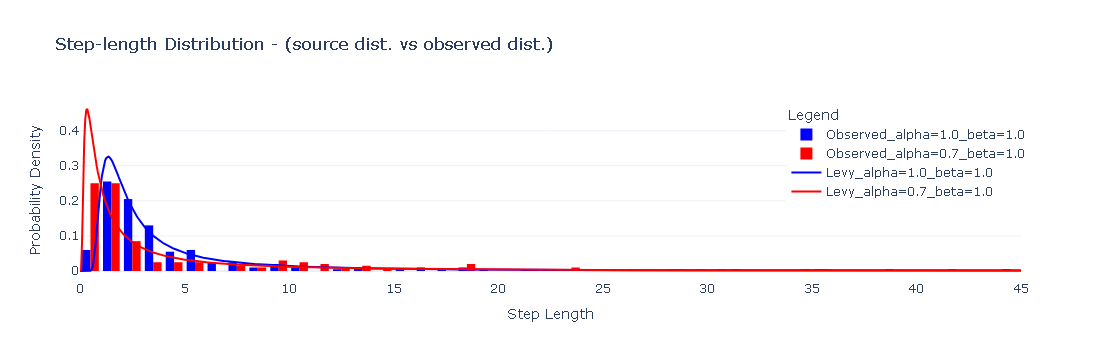

In [48]:
# Create the figure
fig = go.Figure()

# Plot the observed distributions for LW1 and LW2
fig.add_trace(go.Histogram(
    x=step_lengths1,
    name='Observed_alpha=1.0_beta=1.0',
    histnorm='probability density',
    xbins=dict(size=1),
    marker_color='blue'
))
fig.add_trace(go.Histogram(
    x=step_lengths2,
    name='Observed_alpha=0.7_beta=1.0',
    histnorm='probability density',
    xbins=dict(size=1),
    marker_color='red'
))

# Plot the theoretical distributions for LW1 and LW2
x_values = np.linspace(0, 50, 1000)
levy_dist1 = levy_stable.pdf(x_values, alpha1, beta1)
levy_dist2 = levy_stable.pdf(x_values, alpha2, beta2)
fig.add_trace(go.Scatter(
    x=x_values,
    y=levy_dist1,
    mode='lines',
    name='Levy_alpha=1.0_beta=1.0',
    line=dict(color='blue', width=2)
))
fig.add_trace(go.Scatter(
    x=x_values,
    y=levy_dist2,
    mode='lines',
    name='Levy_alpha=0.7_beta=1.0',
    line=dict(color='red', width=2)
))

# Customize the figure
fig.update_layout(
    title="Step-length Distribution - (source dist. vs observed dist.)",
    xaxis_title="Step Length",
    yaxis_title="Probability Density",
    legend_title="Legend",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=1.01
    ),
    template="plotly_white"
)

# Set the x-axis limits
fig.update_xaxes(range=[0, 45])

fig.show()